In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_json("grammarly_data_exercise.json")

In [3]:
df1=df.copy()

In [4]:
df.head()

,date,isFirst,timestamp,uid,utmSource
0,2016-02-29,False,2016-02-29 08:00:01.255,g4Hjpoji4dmv,Biznesowe+Rewolucje
1,2016-02-29,False,2016-02-29 08:00:01.556,g4Hjpoji4dmv,Biznesowe+Rewolucje
2,2016-02-29,False,2016-02-29 08:00:01.770,75121338,program
3,2016-02-29,False,2016-02-29 08:00:03.129,11l0tD2wFPFO,None
4,2016-02-29,False,2016-02-29 08:00:03.610,56429432,None


The data has 5 columns: 

date: date of the ping

timestamp: ping timestamp

uid: unique id assigned to users (if the string is purely numeric, this means the user is registered, otherwise it's a device id)

isFirst: true if this is the user's first ping ever (some users have been using the app before February)

utmSource: traffic source from which the user came

In [5]:
df.shape

(4823567, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4823567 entries, 0 to 4823566
Data columns (total 5 columns):
date         datetime64[ns]
isFirst      bool
timestamp    datetime64[ns]
uid          object
utmSource    object
dtypes: bool(1), datetime64[ns](2), object(2)
memory usage: 151.8+ MB


# Table of Contents (with hyperlinks)

- [Cleaning](#A) 
- [Question 1: Show the daily active users over the month, including all users (first time and recurring). A user is considered active if they pinged at least once on a given day.](#B) 
- [Question 2: Calculate the daily retention curve for users who used the app for the first time on the following dates: Feb 4th, Feb 10th, and Feb 14th. Also, show the number of users from each cohort.](#C)
- [Question 3: Determine if there are any differences in usage based on where the users came from. From which traffic source does the app get its best users? Its worst users?](#D)
- [Analysis](#E)
- [Summary](#G)
- [Future Work](#F)

# Cleaning <a id="A"></a>


###	Null values:
-	Find out the null values in the dataframe
-	utmSource had 1674386 null values
-	Created a new column ‘trafficSource’ where null values are marked as ‘undefined’


###	Merge Traffic Sources:
- Merged traffic Sources using regular expression: blog.* to blog, facebook.* to facebook, 	      gplus.* to google, shmoop.* to shmoop, twitter.* to twitter
- Merged the traffic sources with < than 1000 unique users to ‘others’.
- Finally reduced the number of traffic sources from 52 to 11.

In [7]:
df.describe()

,date,isFirst,timestamp,uid,utmSource
count,4823567,4823567,4823567,4823567,3149181
unique,29,2,4802369,246840,52
top,2016-02-29 00:00:00,False,2016-02-25 19:46:44.202000,vwLJO2uDWrXr,Biznesowe+Rewolucje
freq,194747,4736834,18,2853,1780384
first,2016-02-01 00:00:00,NaN,2016-02-01 08:00:01.230000,NaN,NaN
last,2016-02-29 00:00:00,NaN,2016-03-01 07:59:58.557000,NaN,NaN


In [8]:
#Let's check for null values
df.isnull().sum()

date               0
isFirst            0
timestamp          0
uid                0
utmSource    1674386
dtype: int64

Looks like utmSource has a lot of null values. Almost ~34% of the values are null.

In [9]:
#Created a new column ‘trafficSource’ where null values are marked as ‘undefined’
df['trafficSource']=df['utmSource'].fillna('undefined')
df['trafficSource'].isnull().sum()

0

In [10]:
df['trafficSource']= df['trafficSource'].str.lower()
np.sort(df['trafficSource'].unique())

array(['answers', 'bing', 'biznesowe+rewolucje', 'blog', 'blog_org',
       'blogger_outreach', 'book+quote', 'brand', 'cafemom.com', 'card',
       'contenthub', 'dict', 'digg', 'display', 'email-sendgrid',
       'facebook', 'facebook.com', 'facebook_org', 'google', 'gplus_org',
       'grub+street', 'gsp', 'handbook',
       'just-in-time+travels+newsletter', 'linkedin_org', 'liveintent',
       'membershipcancellation', 'mosalingua+fr', 'nettedbythewebbys',
       'other', 'outbrain', 'pandora', 'placement', 'pre-quote+list',
       'program', 're:+charity', 'salesmanago',
       "sarah+doody's+ux+notebook", 'sendgrid.com', 'shmoop_left',
       'shmoop_logo', 'shmoop_right', 'sticky blogging secrets',
       'summerinvite', 'taboola', 'tapjoy', 'trialintro', 'twitter',
       'twitter_org', 'undefined', 'wise+ink+master+email+list',
       'youtube'], dtype=object)

In [11]:
#merged traffic Sources using regular expression
df['trafficSource'] = df['trafficSource'].str.replace('blog.*', 'blog', regex=True)
df['trafficSource'] = df['trafficSource'].str.replace('facebook.*', 'facebook', regex=True)
df['trafficSource'] = df['trafficSource'].str.replace('gplus.*', 'google', regex=True)
df['trafficSource'] = df['trafficSource'].str.replace('shmoop.*', 'shmoop', regex=True)
df['trafficSource'] = df['trafficSource'].str.replace('twitter.*', 'twitter', regex=True)
df['trafficSource'].nunique()

44

In [12]:
#number of unique users grouped by traffic source
groupbysrc= pd.DataFrame(df.groupby(['trafficSource']).nunique()['uid']).sort_values(by=['uid'])
groupbysrc

,uid
trafficSource,
summerinvite,1
gsp,1
sarah+doody's+ux+notebook,1
brand,1
cafemom.com,1
card,1
sendgrid.com,1
taboola,1
display,1


We have a lot of traffic sources with very less unique users. Can merge them into one source.

In [13]:
#Merge the traffic sources with less than 1000 unique users to 'others'.
small_groups=groupbysrc[groupbysrc['uid']<1000].index.tolist()
for x in small_groups:
    df['trafficSource']=df['trafficSource'].str.replace(x,'other', regex=False)
df['trafficSource'].unique()

array(['biznesowe+rewolucje', 'program', 'undefined', 'answers', 'shmoop',
       'twitter', 'other', 'mosalingua+fr', 'salesmanago', 'handbook',
       'grub+street'], dtype=object)

Finally reduced the number of traffic sources from 52 to 11.

# Question 1: <a id="B"></a>
### Show the daily active users over the month, including all users (first time and recurring). A user is considered active if they pinged at least once on a given day.

In [15]:
df.head()

,date,isFirst,timestamp,uid,utmSource,trafficSource
0,2016-02-29,False,2016-02-29 08:00:01.255,g4Hjpoji4dmv,Biznesowe+Rewolucje,biznesowe+rewolucje
1,2016-02-29,False,2016-02-29 08:00:01.556,g4Hjpoji4dmv,Biznesowe+Rewolucje,biznesowe+rewolucje
2,2016-02-29,False,2016-02-29 08:00:01.770,75121338,program,program
3,2016-02-29,False,2016-02-29 08:00:03.129,11l0tD2wFPFO,None,undefined
4,2016-02-29,False,2016-02-29 08:00:03.610,56429432,None,undefined


In [16]:
#Users which started using the app in February
dfu= df[df['isFirst']==True]['uid'].unique() 
df_feb = df[(df['uid'].isin(dfu))]
df_feb.head()

,date,isFirst,timestamp,uid,utmSource,trafficSource
2,2016-02-29,False,2016-02-29 08:00:01.770,75121338,program,program
3,2016-02-29,False,2016-02-29 08:00:03.129,11l0tD2wFPFO,None,undefined
4,2016-02-29,False,2016-02-29 08:00:03.610,56429432,None,undefined
7,2016-02-29,False,2016-02-29 08:00:03.834,60022150,answers,answers
10,2016-02-29,False,2016-02-29 08:00:04.514,nZiBNGPSep0s,None,undefined


In [18]:
#Daily active users for users who started in February
daily_active_feb= df_feb.groupby(['date']).nunique()['uid']
daily_active_feb

date
2016-02-01     3071
2016-02-02     4805
2016-02-03     6279
2016-02-04     7485
2016-02-05     7792
2016-02-06     8134
2016-02-07     9988
2016-02-08    12121
2016-02-09    13427
2016-02-10    14943
2016-02-11    16043
2016-02-12    15650
2016-02-13    15312
2016-02-14    17695
2016-02-15    21169
2016-02-16    21221
2016-02-17    23183
2016-02-18    24214
2016-02-19    23446
2016-02-20    23295
2016-02-21    27796
2016-02-22    30885
2016-02-23    32635
2016-02-24    34043
2016-02-25    34737
2016-02-26    32910
2016-02-27    32094
2016-02-28    37289
2016-02-29    41063
Name: uid, dtype: int64

In [19]:
#Total Number of active users
daily_active_users= df.groupby(['date']).nunique()['uid']
daily_active_users

date
2016-02-01    112504
2016-02-02    112317
2016-02-03    113062
2016-02-04    111098
2016-02-05    102420
2016-02-06     94807
2016-02-07    104175
2016-02-08    114802
2016-02-09    115859
2016-02-10    117113
2016-02-11    115290
2016-02-12    106132
2016-02-13     97788
2016-02-14    106158
2016-02-15    119409
2016-02-16    120874
2016-02-17    122053
2016-02-18    120374
2016-02-19    112452
2016-02-20    104665
2016-02-21    120306
2016-02-22    130017
2016-02-23    131707
2016-02-24    131947
2016-02-25    130334
2016-02-26    120658
2016-02-27    112789
2016-02-28    128096
2016-02-29    138644
Name: uid, dtype: int64

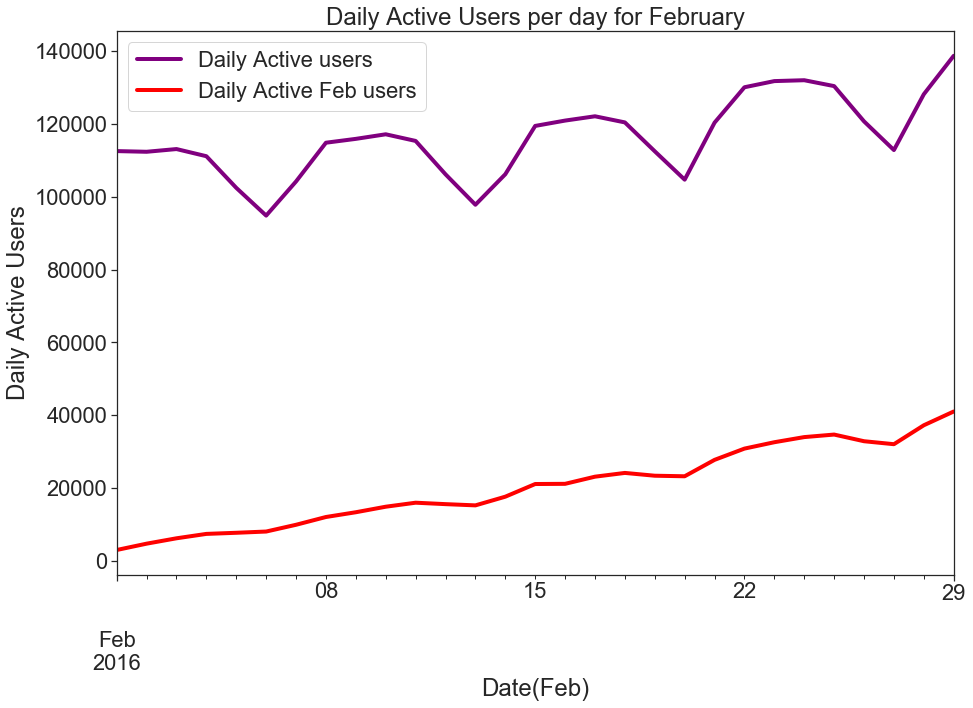

In [52]:
sns.set(font_scale=2,rc={'figure.figsize':(15, 10)})
sns.set_palette("brg",3)
sns.set_style("ticks")
fig, ax = plt.subplots()
daily_active_users.plot(ax=ax, linewidth=4, label='Daily Active users')
daily_active_feb.plot(ax=ax, linewidth=4, label='Daily Active Feb users')
plt.xlabel("Date(Feb)")
plt.ylabel("Daily Active Users")
plt.title("Daily Active Users per day for February")
plt.legend()

Figure shows the daily active users (DAU) for the month of February. I have plotted 2 plots: one is the DAU for all the users (purple). Second is the plot for DAU who started in February (red). As we can see from the graph, the Feb users are increasing in number but the total DAU graph shows some dips, that could be attributed to less usage during the weekends.

# Question 2 <a id="C"></a>
### Calculate the daily retention curve for users who used the app for the first time on the following dates: Feb 4th, Feb 10th, and Feb 14th. Also, show the number of users from each cohort.
#### Daily retention curve is defined as the % of users from the cohort, who used the product that day. 

In [22]:
def dailyRetention(df,date):
    cohort=df[(df['isFirst']== True) & (df['date'] == date)]
    num_of_users= cohort['uid'].nunique()
    print("Number of distinct users on %s:" %date, num_of_users)
    list_cohort= cohort['uid'].unique()
    #print(list_cohort)
    df_cohort= df[df['uid'].isin(list_cohort)]
    #print(df_cohort)
    cohort_data=pd.DataFrame((df_cohort.groupby(['date']).nunique()['uid']/num_of_users*100).round(2))
    #cohort_count=cohort_data.pivot_table(index='date', columns='df_cohort', values='uid')
    return cohort_data

In [23]:
dates=['2016-2-4', '2016-2-10', '2016-2-14']
ret_04= dailyRetention(df, '2016-02-04')
ret_10= dailyRetention(df, '2016-02-10')
ret_14= dailyRetention(df, '2016-02-14')

ret_04['CohortIndex']= '2016-02-04'
ret_10['CohortIndex']= '2016-02-10'
ret_14['CohortIndex']= '2016-02-14'

arr= np.arange(1,30,1)
#print(arr)
#print(perc_04, perc_10, perc_14)
ret_04.insert(0, 'day', range(1, 1 + len(ret_04)))
ret_10.insert(0, 'day', range(1, 1 + len(ret_10)))
ret_14.insert(0, 'day', range(1, 1 + len(ret_14)))

perc_list=[ret_04, ret_10, ret_14]
cohort_count= pd.concat(perc_list)
cohort_pivot= cohort_count.pivot(index='CohortIndex', 
                                 columns='day', values='uid')
print(cohort_pivot)

Number of distinct users on 2016-02-04: 2735
Number of distinct users on 2016-02-10: 3129
Number of distinct users on 2016-02-14: 2761
day             1      2      3      4      5      6      7      8      9   \
CohortIndex                                                                  
2016-02-04   100.0  54.48  43.95  46.29  48.01  44.10  43.77  43.29  37.18   
2016-02-10   100.0  60.56  50.69  43.72  46.37  49.44  48.77  48.32  45.22   
2016-02-14   100.0  60.92  55.05  51.50  47.48  43.75  42.99  47.41  45.74   

day             10  ...     17     18     19     20     21     22     23  \
CohortIndex         ...                                                    
2016-02-04   33.64  ...  31.59  36.64  38.50  38.14  38.35  37.44  33.09   
2016-02-10   41.87  ...  38.73  36.88  40.75  43.46    NaN    NaN    NaN   
2016-02-14   44.04  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

day             24     25     26  
CohortIndex                       
2016-02-04   30.31  34.

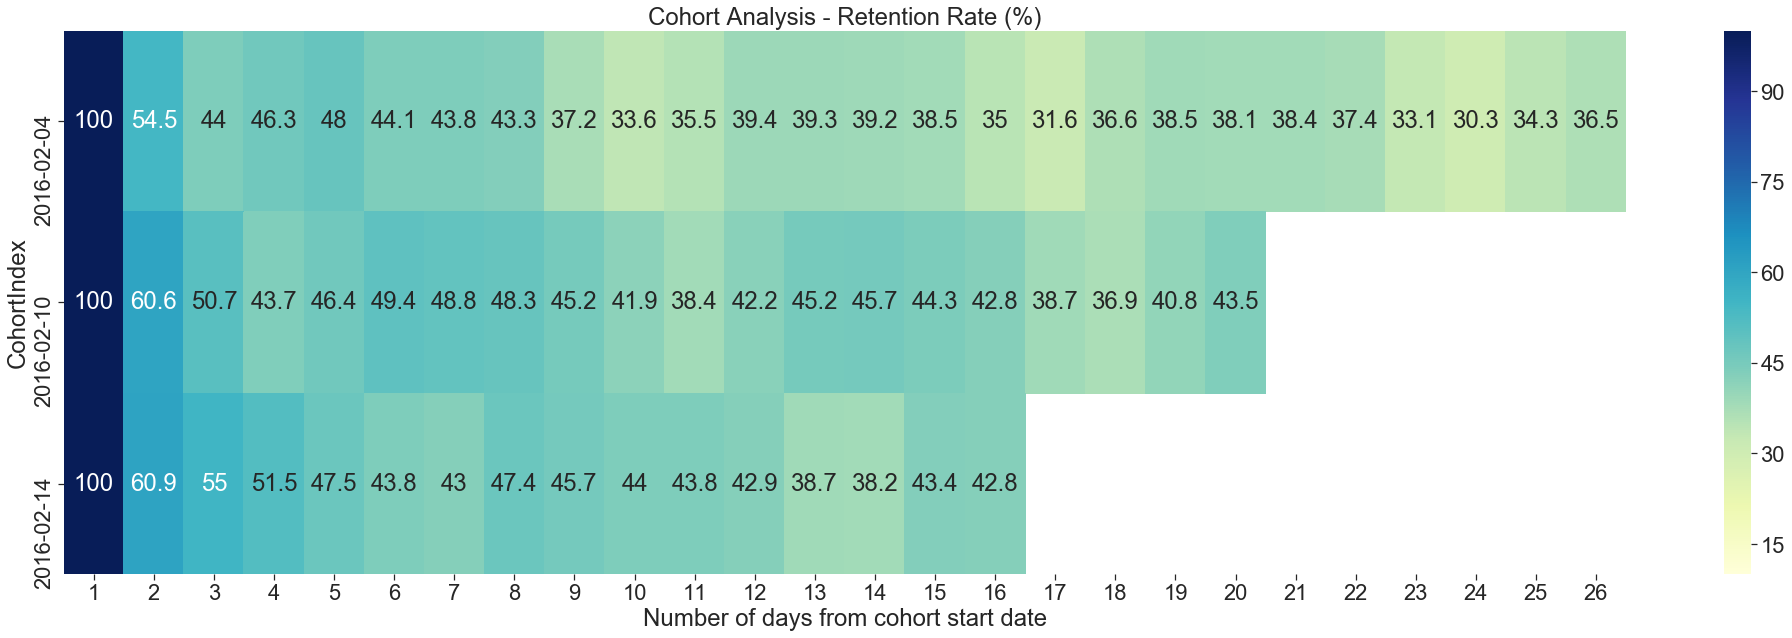

In [47]:
plt.figure(figsize = (35,10))
plt.title('Cohort Analysis - Retention Rate (%)')
sns.heatmap(data = cohort_pivot, 
            annot = True,
            cbar = True,
            fmt='0.3g',
            vmin = 10,
            vmax = 100,
            cmap = "YlGnBu")
plt.xlabel('Number of days from cohort start date')
plt.show()

I have created the cohort for the given dates and calculated user retention for each day of February.
	Figure 2 shows a heatmap for the daily retention for users who used the app for the first time on : 
	Feb 4th, Feb 10th and Feb 14th. From the heatmap we can see 100% retention on the first day of usage. 	And retention decreases to as low as ~31% for some of the days.

In [26]:
#let's plot the daily retention curve.
def dailyRetentioncurve(df,date):
    cohort=df[(df['isFirst']== True) & (df['date'] == date)]
    num_of_users= cohort['uid'].nunique()
    list_cohort= cohort['uid'].unique()
    df_cohort= df[df['uid'].isin(list_cohort)]
    cohort_data=(df_cohort.groupby(['date']).nunique()['uid']/num_of_users)
    return cohort_data

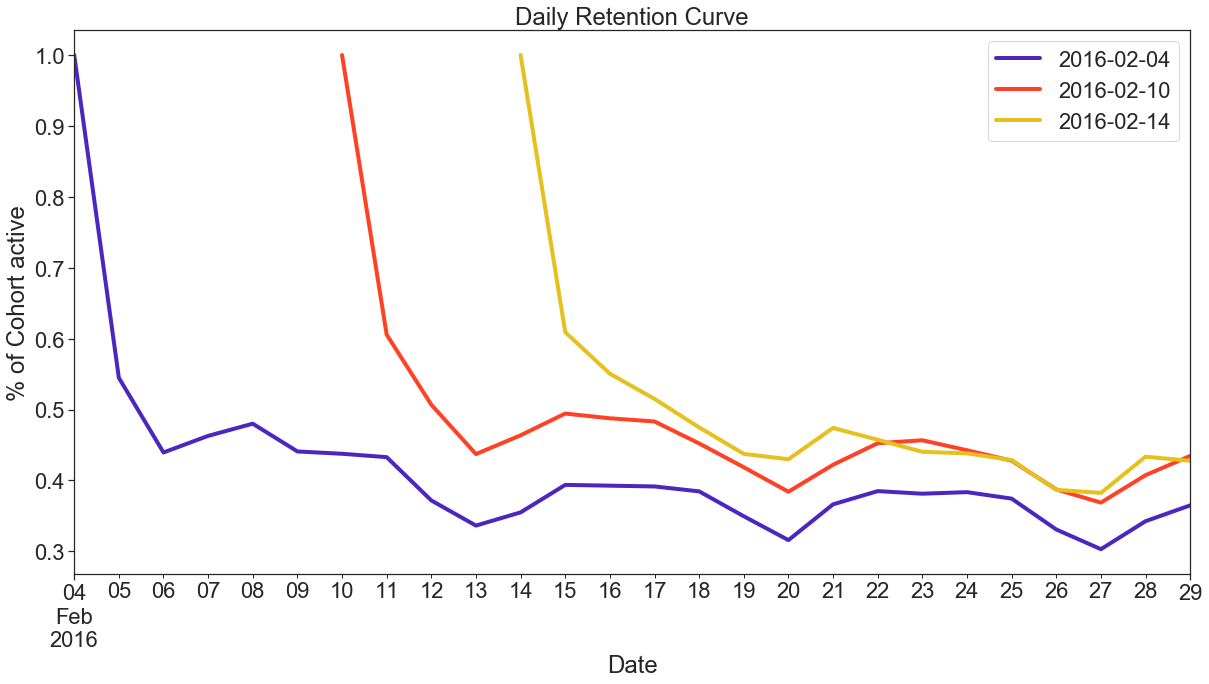

In [27]:
sns.set_palette("CMRmap",3)
fig, ax = plt.subplots(figsize=(20,10))
dates=['2016-02-04', '2016-02-10', '2016-02-14']
for date in dates:
    ret_date=dailyRetentioncurve(df,date)
    ret_date.plot(ax=ax, linewidth='4', label= date)
plt.title('Daily Retention Curve')
plt.xlabel('Date')
plt.ylabel('% of Cohort active')
plt.legend()
plt.show()

Figure 3 shows the Daily retention curve. Intially the retention is 100% but it keeps on decreasing and becomes stable after a week.

Text(0, 0.5, 'Number of Users')

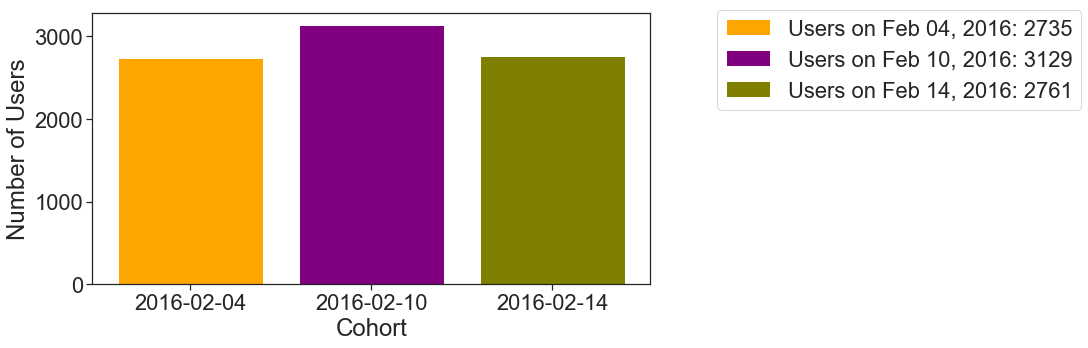

In [35]:
#Plot the number of users for each cohort
plt.figure(figsize=(10,5))
plt.bar('2016-02-04',2735, label='Users on Feb 04, 2016: 2735', color='Orange')
plt.bar('2016-02-10',3129, label='Users on Feb 10, 2016: 3129', color='Purple')
plt.bar('2016-02-14',2761, label='Users on Feb 14, 2016: 2761', color='Olive')

plt.xlabel('Cohort')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel('Number of Users') 

Figure 4 shows the unique users from each cohort.

In [50]:
def numberofusersretained(df,date):
    cohort=df[(df['isFirst']== True) & (df['date'] == date)]
    num_of_users= cohort['uid'].nunique()
    list_cohort= cohort['uid'].unique()
    df_cohort= df[df['uid'].isin(list_cohort)]
    cohort_data=pd.DataFrame((df_cohort.groupby(['date']).nunique()['uid']))
    return cohort_data

dates=['2016-2-4', '2016-2-10', '2016-2-14']
perc_04= numberofusersretained(df, '2016-02-04')
perc_10= numberofusersretained(df, '2016-02-10')
perc_14= numberofusersretained(df, '2016-02-14')

perc_04['CohortIndex']= '2016-02-04'
perc_10['CohortIndex']= '2016-02-10'
perc_14['CohortIndex']= '2016-02-14'

arr= np.arange(1,30,1)
#print(arr)
#print(perc_04, perc_10, perc_14)
perc_04.insert(0, 'day', range(1, 1 + len(perc_04)))
perc_10.insert(0, 'day', range(1, 1 + len(perc_10)))
perc_14.insert(0, 'day', range(1, 1 + len(perc_14)))

perc_list=[perc_04, perc_10, perc_14]
cohort_count= pd.concat(perc_list)
cohort_users_retained= cohort_count.pivot(index='CohortIndex', 
                                 columns='day', values='uid')
print(cohort_users_retained)

day              1       2       3       4       5       6       7       8   \
CohortIndex                                                                   
2016-02-04   2735.0  1490.0  1202.0  1266.0  1313.0  1206.0  1197.0  1184.0   
2016-02-10   3129.0  1895.0  1586.0  1368.0  1451.0  1547.0  1526.0  1512.0   
2016-02-14   2761.0  1682.0  1520.0  1422.0  1311.0  1208.0  1187.0  1309.0   

day              9       10  ...      17      18      19      20      21  \
CohortIndex                  ...                                           
2016-02-04   1017.0   920.0  ...   864.0  1002.0  1053.0  1043.0  1049.0   
2016-02-10   1415.0  1310.0  ...  1212.0  1154.0  1275.0  1360.0     NaN   
2016-02-14   1263.0  1216.0  ...     NaN     NaN     NaN     NaN     NaN   

day              22     23     24     25     26  
CohortIndex                                      
2016-02-04   1024.0  905.0  829.0  937.0  998.0  
2016-02-10      NaN    NaN    NaN    NaN    NaN  
2016-02-14      NaN    

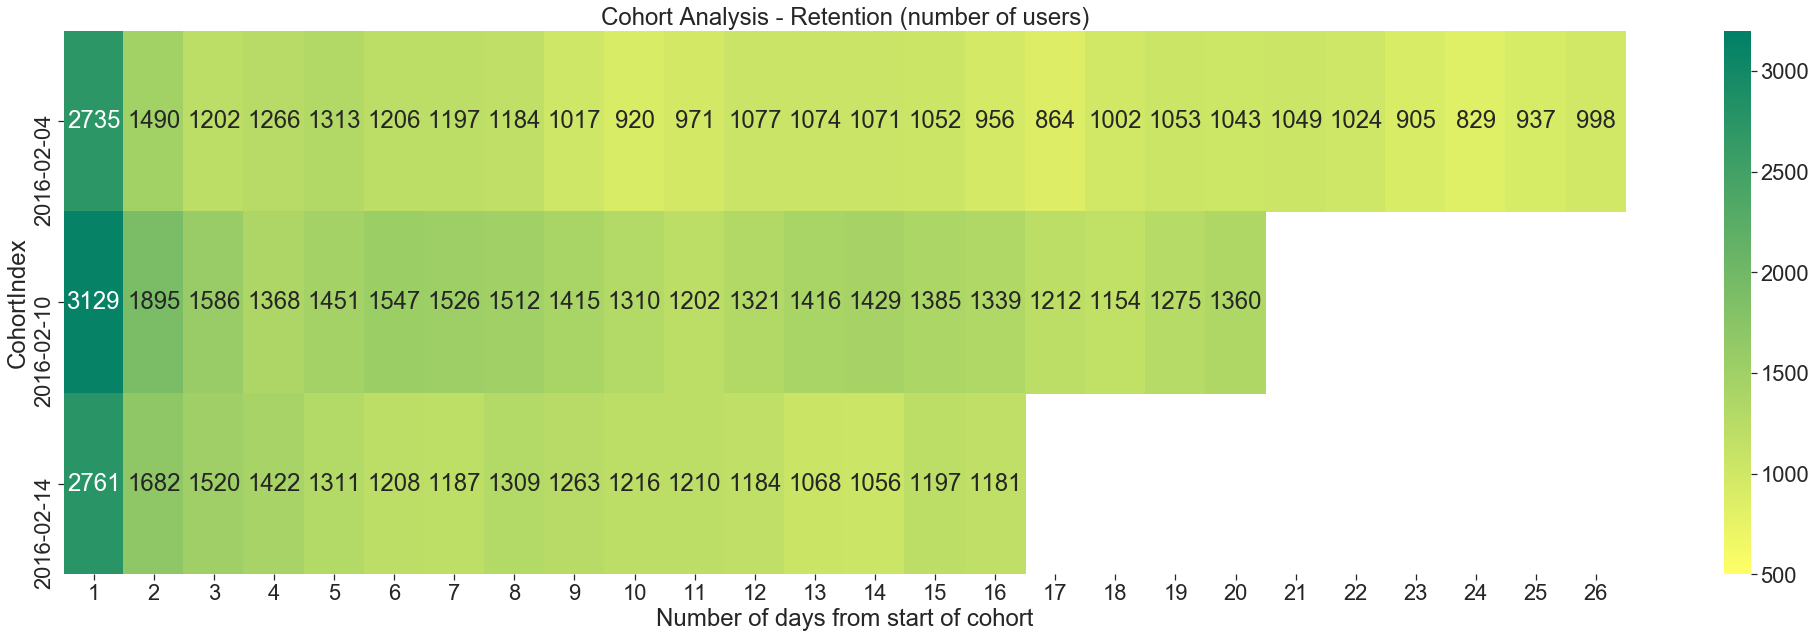

In [51]:
plt.figure(figsize = (35,10))
plt.title('Cohort Analysis - Retention (number of users)')
sns.heatmap(data = cohort_users_retained, 
            annot = True,
            cbar = True,
            fmt='0.4g',
            vmin = 500,
            vmax = 3200,
            cmap = "summer_r")
plt.xlabel('Number of days from start of cohort') 
plt.show()

Figure 5 shows a heatmap for the number of users retained from each cohort over the month of February.

# Question3 <a id="D"> </a>
### Determine if there are any differences in usage based on where the users came from. From which traffic source does the app get its best users? Its worst users? 

In [36]:
#We might have to look at uids with multiple sources and clean the dataset according to that.
n_sources = df.groupby(['uid'])['trafficSource'].nunique()
multiple_src_perc = np.sum(n_sources>1) / df['uid'].nunique()
print(f'{100 * multiple_src_perc:.2f}% of user ids have more than 1 source.')

1.64% of user ids have more than 1 source.


In [37]:
multiple_src_sum_2= np.sum(n_sources>1)
multiple_src_sum_3= np.sum(n_sources>2)
print(multiple_src_sum_2, multiple_src_sum_3)

4058 36


1.64% of user ids i.e. 4058 unique uids have more than 1 source. Because the percentage is small, we can remove that data from our dataframe.

In [38]:
groupbysrc = pd.DataFrame(df.groupby(['uid','trafficSource']).nunique()['date']).reset_index()
multiple_src = groupbysrc.duplicated(subset=['uid'])
multiple_src_grps = groupbysrc[multiple_src]['uid'].unique()

In [39]:
multiple_src_grps.shape

(4058,)

In [41]:
drop_users=[users for users in multiple_src_grps]
dfa = df[~df['uid'].isin(drop_users)]
dfa.head()

,date,isFirst,timestamp,uid,utmSource,trafficSource
0,2016-02-29,False,2016-02-29 08:00:01.255,g4Hjpoji4dmv,Biznesowe+Rewolucje,biznesowe+rewolucje
1,2016-02-29,False,2016-02-29 08:00:01.556,g4Hjpoji4dmv,Biznesowe+Rewolucje,biznesowe+rewolucje
2,2016-02-29,False,2016-02-29 08:00:01.770,75121338,program,program
3,2016-02-29,False,2016-02-29 08:00:03.129,11l0tD2wFPFO,None,undefined
4,2016-02-29,False,2016-02-29 08:00:03.610,56429432,None,undefined


In [42]:
#dataframe for total active by unique users per trafficSource per date.
activitybysrc_bydate= dfa.groupby(['trafficSource', 'date']).nunique()['uid']
activitybysrc_bydate.unstack().T

trafficSource,answers,biznesowe+rewolucje,grub+street,handbook,mosalingua+fr,other,program,salesmanago,shmoop,twitter,undefined
date,,,,,,,,,,,
2016-02-01,5703,43927,1708,547,2956,3677,9359,776,4076,3042,35262
2016-02-02,5703,43901,1720,527,3023,3621,9406,760,3997,3019,35100
2016-02-03,5823,44159,1728,548,3013,3626,9391,753,3995,3010,35409
2016-02-04,5755,43320,1664,546,2970,3579,9119,766,3917,2977,34856
2016-02-05,5311,39699,1459,476,2731,3391,8433,672,3677,2833,32176
2016-02-06,5403,36651,1252,460,2537,3113,7607,599,3453,2560,29669
2016-02-07,5740,40631,1462,510,2851,3378,8268,662,3614,2774,32629
2016-02-08,5997,44658,1700,550,3085,3728,9200,744,3939,3076,36281
2016-02-09,5981,45389,1666,535,3128,3781,9113,752,3973,3089,36540


Text(0, 0.5, 'Number of unique users')

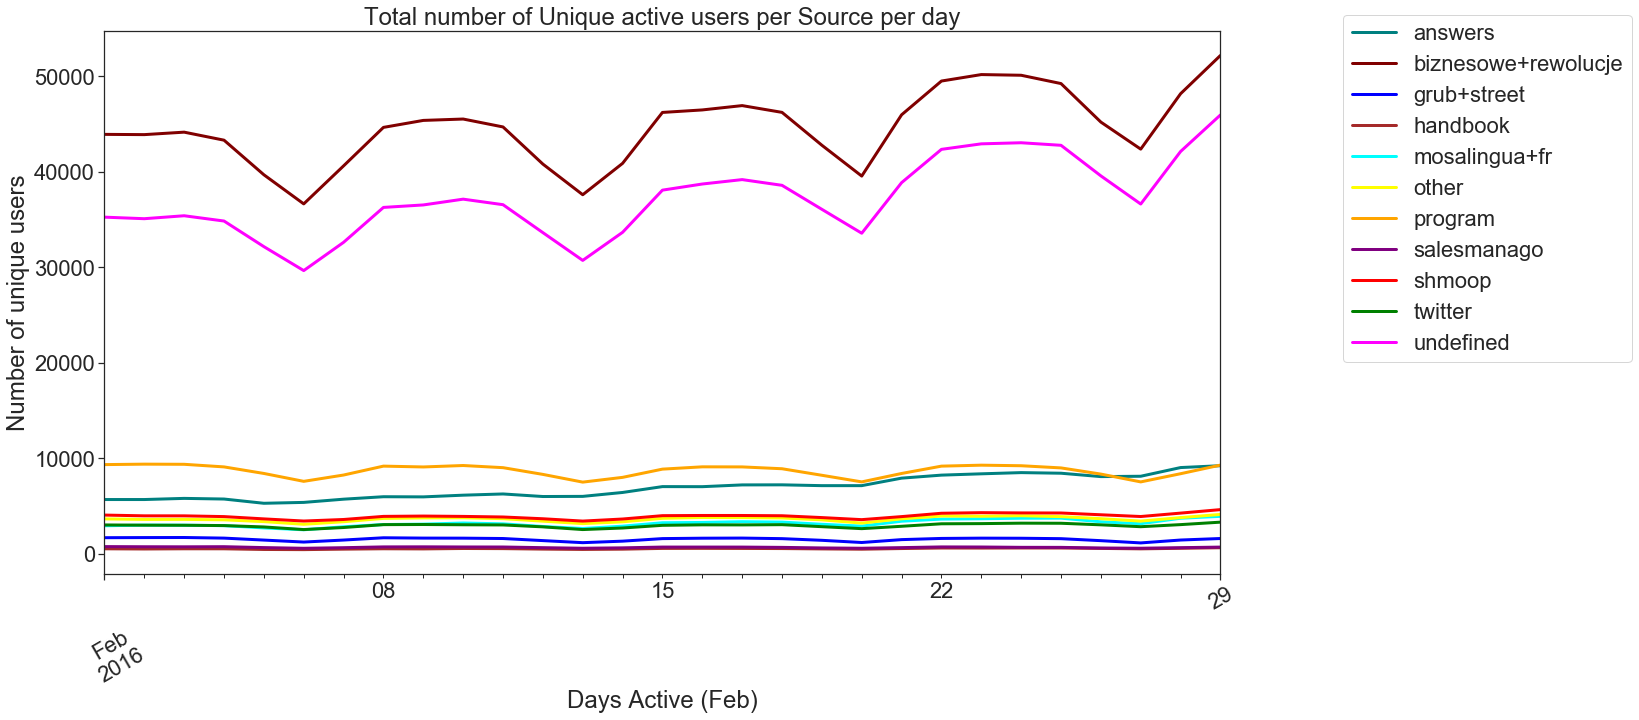

In [43]:
color=['teal', 'maroon', 'blue', 'brown', 'cyan', 'yellow', 'orange', 'purple', 'red', 'green', 'magenta']
fig, ax = plt.subplots(figsize=(20,10))
activitybysrc_bydate.unstack().T.plot(ax=ax, kind='line',linewidth=3, color=color)
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Total number of Unique active users per Source per day')
plt.xlabel('Days Active (Feb)')
plt.ylabel('Number of unique users')

Metric: Total number of unique active users per Source per day.
The first metric I have calculated is purely quantitative on the basis of how many users we are getting from each source and there activity per day throughout the month. 

Figure 5 plots this information using line plot. From the plot you can see that biznesowe+rewolucje and undefined sources are getting the most users but there is a dip in the usage on weekends. And sources like program, answers, shmoop, twitter, grub+street and handbook have constant usage throughout the month. 

In [45]:
# dataframe of total active days per user per source
days_active_bysrc = dfa.groupby(['trafficSource','uid']).nunique()['date']
days_active_bysrc.unstack().T

trafficSource,answers,biznesowe+rewolucje,grub+street,handbook,mosalingua+fr,other,program,salesmanago,shmoop,twitter,undefined
uid,,,,,,,,,,,
007lqy8pw8PF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
008wXBXcFOF5,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00BBLeYvGxwU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
00Dd47PrCevO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
00FhDR8eh9W0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
00Gf1l2czzwc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
00ImPq5wOWHs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
00SEgJMYLRBP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
00X99FtrcUOu,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 0, 'Days Active (Feb)')

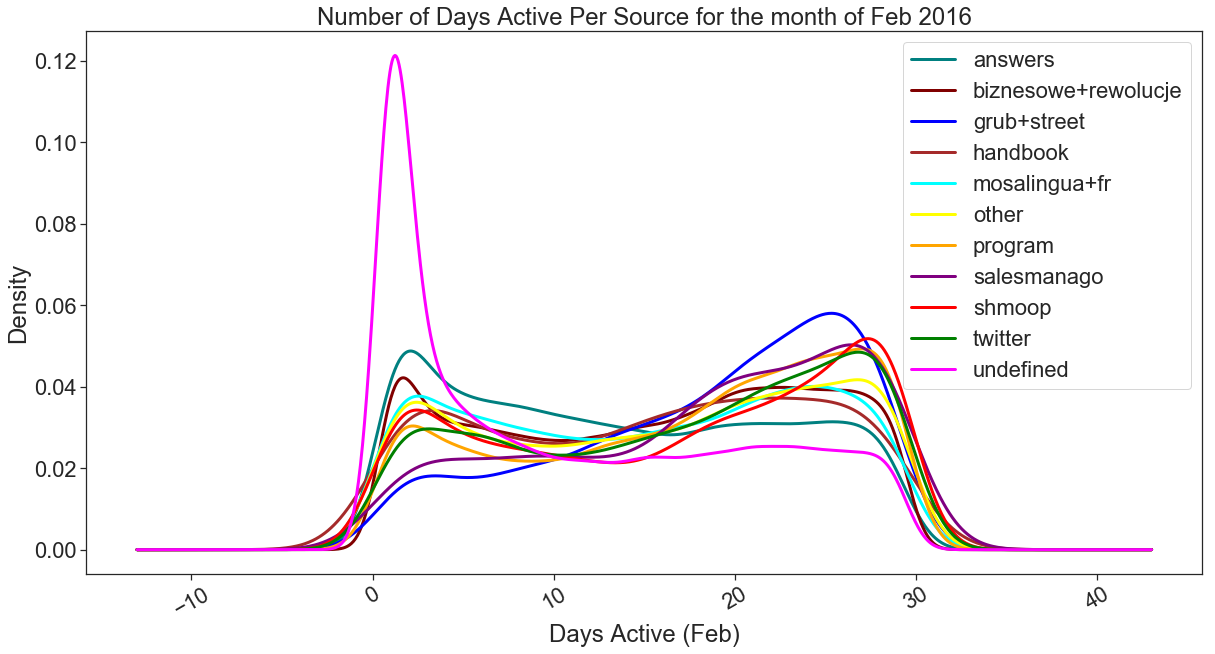

In [46]:
color=['teal', 'maroon', 'blue', 'brown', 'cyan', 'yellow', 'orange', 'purple', 'red', 'green', 'magenta']
sns.set_palette("rainbow_r",3)
fig, ax = plt.subplots(figsize=(20,10))
days_active_bysrc.unstack().T.plot(ax=ax, kind='kde',linewidth=3, color=color)
plt.xticks(rotation=30)
plt.legend()
plt.title('Number of Days Active Per Source for the month of Feb 2016')
plt.xlabel('Days Active (Feb)')

Metric: Number of days active/source
The second  metric that I have considered is to calculate the Number of days active/source. For this I have grouped the data per traffic source and uid and counted the number of unique dates. So this tells the number of days for each traffic source, each uid was active. I have plotted this information on a KDE graph and by first look of the graph the distribution for all sources seems to be bimodal with  peeks  near 0 and 29 days. The best traffic sources can be defined as ones with peak at 29 and the worst ones with a peak at 0.

Figure 6 shows us a KDE graph for the number of days active per source for the month of Feb. From the graph it can be seen that best sources with a mode at 29 (most of the users from these source used the app for 29 days) are shmoop and twitter closely followed by program, salesmanago and grub+street with peaks at 29, 28 and 27 respectively. The worst source is the undefined with a mode of 0 despite getting the most users, followed by answers and biznesowe+rewolucje. If I were to define the traffic sources from best to worst based on this graph above: shmoop, twitter, program, salesmanago, grub+street, other, handbook, mosalingua+fr, biznesowe+rewolucje, answers, undefined


## Analysis <a id="E"> </a>

User behaviour depends on the kind of metric that is important for a business. For some businesses daily activity(pings) can be an important metric. For some businesses more activity (pings) on certain days of the month has more weightage than the daily activity. We could refine the definition of worst users and best users on the basis of what is important for the company.

## Summary <a id="G"> </a>
So to summarize the above findings, I would like to say that if total number of unique active users is an important metric for us than the first graph can be used to see which sources are best/worst. Where more number of users implies best traffic source. 

But if we want to see there activity over the month and analyse how many days the users from a particular source were active for the month then the second metric is important. In this case we found out that even if the source (eg Shmoop, twitter) is giving lesser number of unique active users per day, the users which are coming are using the app for a longer period of time. 

# Future Work <a id ="F"> </a>

1) Data cleaning: Instead of removing the data for users with duplicate sources. If one of the sources is ‘undefined’ or ’other’, then replace that data with an actual traffic source.

2) Analyse two metrics for defining best and worst users:
- Total activity by users for the entire month per traffic source (this includes multiple pings on same day)
- User activity on different days per traffic source.
      
       Calculate the total weight for a traffic source.
                                     Total weight (traffic source)= x*a + y*b
       where x and y are the weights assigned to metrics a and b and can be increased/decreased based      
       on what is more important for the business.
